<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg" align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">Trabajo Fin de Máster</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Autor: César Fernández Domínguez</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# Análisis descriptivo de datos de contaminación del aire para la ciudad de Barcelona

Este análisis se ha organizado en los siguientes apartados:

 <ol start="1">
  <li>Carga del conjunto de datos</li>
  <li>Análisis de los datos
  <br>2.1 Análisis estadístico básico
  <br>2.2 Análisis exploratorio de los datos
</ol>
   
En primer lugar, cargamos todas las librerías que vamos a necesitar:

In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import folium
import random
import seaborn;
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
from matplotlib.pylab import rcParams
from statistics import mean
%matplotlib inline
pd.set_option('display.max_columns', None)
rcParams['figure.figsize'] = 12, 8
rcParams['font.size'] = 10

# 1. Carga del conjunto de datos

El objetivo principal de este trabajo es el construir un modelo capaz de predecir la concentración de contaminantes en el aire en la ciudad de Barcelona. Para realizar este modelo, en primer lugar, debemos de contar con registros de datos de inmisión. La comunidad autónoma de Cataluña ofrece estos datos, en abierto, a través de su portal de [Open Data](https://analisi.transparenciacatalunya.cat/es). Concretamente en el enlace enlace: [aqui](https://analisi.transparenciacatalunya.cat/es/Medi-Ambient/Dades-d-immissi-dels-punts-de-mesurament-de-la-Xar/uy6k-2s8r), encontramos datos de inmisión de los puntos de medición de la Red de Vigilancia y Previsión de la Contaminación Atmosférica de Cataluña. Estos datos se ofrecen con distinta periodicidad horaria para distintos contaminantes del aire. Se tienen datos desde el año 1991 hasta el día anterior a la actual. En nuestro caso, nos interesan los datos registrados desde enero de 2010, en las estaciones de vigilancia ubicadas en la ciudad de Barcelona. Esta información se actualiza diariamente. Aparte de la concentración de los diferentes contaminantes también se podrá consultar: las coordenadas donde está ubicado el punto de medición, el tipo de estación, las unidades y la fecha de alta y de baja.

Estos datos se ofrecen con Licencia: [Open Data Commons Attribution License](https://opendatacommons.org/licenses/by/1.0/)

El siguiente código nos permite cargar los datos de inmisión, disponibles entre dos meses, en la ciudad de Barcelona (los datos predescargados están filtrados para Barcelona). Para ello, debemos modificar los valores asignados a las variables 'dataStartTime' y 'dataEndTime'.

In [2]:
dataStartTime = "2019-01"
dataEndTime = "2020-03"

# Header definition
columns=['CODI_MESURAMENT','CODI_EOI','PROVINCIA','CODI_MUNICIPI','CODI_ESTACIO','NOM_ESTACIO','MUNICIPI',
         'LATITUD','LONGITUD','ALTITUD','TIPUS_ESTACIO','AREA URBANA','MAGNITUD','CONTAMINANT','UNITATS',
         'PUNT_MOSTREIG','ANY','MES','DIA','DATA','H01','V01','H02','V02','H03','V03','H04','V04','H05','V05',
         'H06','V06','H07','V07','H08','V08','H09','V09','H10','V10','H11','V11','H12','V12','H13','V13',
         'H14','V14','H15','V15','H16','V16','H17','V17','H18','V18','H19','V19','H20','V20','H21','V21',
         'H22','V22','H23','V23','H24','V24','Georeferencia']
dtype={'CODI_MESURAMENT':object,
       'CODI_EOI':object,'PROVINCIA':object,'CODI_MUNICIPI':object,
       'CODI_ESTACIO':object,'NOM_ESTACIO':object,'MUNICIPI':object,
       'LATITUD':np.number,'LONGITUD':np.number,'ALTITUD':np.number,
       'TIPUS_ESTACIO':object,'AREA URBANA':object,'MAGNITUD':object,
       'CONTAMINANT':object,'UNITATS':object,'PUNT_MOSTREIG':object,
       'ANY':object,'MES':object,'DIA':object,'DATA':object,
       'H01':np.number,'V01':np.character,'H02':np.number,'V02':np.character,'H03':np.number,'V03':np.character,
       'H04':np.number,'V04':np.character,'H05':np.number,'V05':np.character,'H06':np.number,'V06':np.character,
       'H07':np.number,'V07':np.character,'H08':np.number,'V08':np.character,'H09':np.number,'V09':np.character,
       'H10':np.number,'V10':np.character,'H11':np.number,'V11':np.character,'H12':np.number,'V12':np.character,
       'H13':np.number,'V13':np.character,'H14':np.number,'V14':np.character,'H15':np.number,'V15':np.character,
       'H16':np.number,'V16':np.character,'H17':np.number,'V17':np.character,'H18':np.number,'V18':np.character,
       'H19':np.number,'V19':np.character,'H20':np.number,'V20':np.character,'H21':np.number,'V21':np.character,
       'H22':np.number,'V22':np.character,'H23':np.number,'V23':np.character,'H24':np.number,'V24':np.character,
       'Georeferencia':object}

# Read data to dataframe
data_air = pd.DataFrame(columns=columns)
for time in pd.date_range(dataStartTime+"-01T00:00:00.000", dataEndTime+"-01T00:00:00.000", freq='MS'):
    filename = time.strftime("../data/aire/aire_%Y_%m.zip")
    #print(filename)
    data_air = data_air.append(
        #pd.read_csv(filename, names=columns, sep=';', encoding = "ISO-8859-1", dtype=dtype)
        pd.read_csv(filename, names=columns, sep=';', encoding = "UTF-8", dtype=dtype)
        , ignore_index = True)

In [3]:
data_air.shape

(25432, 69)

Comprobamos que no se ha cargado ninguna instancia repetida. Si así fuera, tendríamos que eliminar aquellas que se repitan.

In [4]:
# Check whether duplicated rows and remove them, if so
duplicateRowsDF = data_air[data_air.duplicated()]
if len(duplicateRowsDF):
    data_air.drop_duplicates(inplace=True)  
    
print("Número de instancias duplicadas eliminadas: %d" % (len(duplicateRowsDF))) 

Número de instancias duplicadas eliminadas: 0


Mostramos las primeras instancias de nuestro dataframe para ver cómo son nuestros datos:

In [5]:
# Show first values in dataframe
data_air.head()

,CODI_MESURAMENT,CODI_EOI,PROVINCIA,CODI_MUNICIPI,CODI_ESTACIO,NOM_ESTACIO,MUNICIPI,LATITUD,LONGITUD,ALTITUD,TIPUS_ESTACIO,AREA URBANA,MAGNITUD,CONTAMINANT,UNITATS,PUNT_MOSTREIG,ANY,MES,DIA,DATA,H01,V01,H02,V02,H03,V03,H04,V04,H05,V05,H06,V06,H07,V07,H08,V08,H09,V09,H10,V10,H11,V11,H12,V12,H13,V13,H14,V14,H15,V15,H16,V16,H17,V17,H18,V18,H19,V19,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24,Georeferencia
0,08019004_12_20190101,8019004,8,19,4,Barcelona (Poblenou),Barcelona,41.40388,2.204501,3.0,background,urban,12,NOX,µg/m3,08019004_12_8,2019,1,1,2019-01-01T00:00:00.000,72.0,V,110.0,V,125.0,V,100.0,V,108.0,V,89.0,V,75.0,V,84.0,V,75.0,V,70.0,V,70.0,V,65.0,V,55.0,V,41.0,V,22.0,V,19.0,V,29.0,V,39.0,V,56.0,V,100.0,V,186.0,V,218.0,V,80.0,V,70.0,V,"(41.40388, 2.204501)"
1,08019004_7_20190101,8019004,8,19,4,Barcelona (Poblenou),Barcelona,41.40388,2.204501,3.0,background,urban,7,NO,µg/m3,08019004_7_8,2019,1,1,2019-01-01T00:00:00.000,14.0,V,39.0,V,50.0,V,36.0,V,42.0,V,30.0,V,22.0,V,28.0,V,23.0,V,22.0,V,23.0,V,19.0,V,14.0,V,9.0,V,4.0,V,3.0,V,4.0,V,4.0,V,4.0,V,20.0,V,73.0,V,95.0,V,12.0,V,8.0,V,"(41.40388, 2.204501)"
2,08019004_8_20190101,8019004,8,19,4,Barcelona (Poblenou),Barcelona,41.40388,2.204501,3.0,background,urban,8,NO2,µg/m3,08019004_8_8,2019,1,1,2019-01-01T00:00:00.000,51.0,V,50.0,V,49.0,V,46.0,V,44.0,V,43.0,V,42.0,V,41.0,V,39.0,V,36.0,V,35.0,V,36.0,V,34.0,V,27.0,V,17.0,V,15.0,V,24.0,V,34.0,V,49.0,V,69.0,V,75.0,V,73.0,V,61.0,V,58.0,V,"(41.40388, 2.204501)"
3,08019042_12_20190101,8019042,8,19,42,Barcelona (Sants),Barcelona,41.37878,2.133099,35.0,background,urban,12,NOX,µg/m3,08019042_12_8,2019,1,1,2019-01-01T00:00:00.000,319.0,V,229.0,V,329.0,V,385.0,V,239.0,V,293.0,V,234.0,V,245.0,V,235.0,V,190.0,V,124.0,V,29.0,V,23.0,V,42.0,V,34.0,V,17.0,V,17.0,V,27.0,V,44.0,V,74.0,V,71.0,V,42.0,V,41.0,V,24.0,V,"(41.37878, 2.133099)"
4,08019042_7_20190101,8019042,8,19,42,Barcelona (Sants),Barcelona,41.37878,2.133099,35.0,background,urban,7,NO,µg/m3,08019042_7_8,2019,1,1,2019-01-01T00:00:00.000,154.0,V,100.0,V,161.0,V,194.0,V,107.0,V,142.0,V,108.0,V,118.0,V,115.0,V,86.0,V,47.0,V,5.0,V,3.0,V,5.0,V,4.0,V,2.0,V,1.0,V,2.0,V,4.0,V,11.0,V,8.0,V,4.0,V,3.0,V,2.0,V,"(41.37878, 2.133099)"


Vemos como los datos están organizados en 69 columnas, que son:

- 'CODI_MESURAMENT', campo único formado por la concatenación de: EOI_Codi contaminant_AnyMesDia.
- 'CODI_EOI', código formado por: Província, Codi_Municipi y Codi_Estació.
- 'PROVINCIA', código numérico correspondiente a la provincia (08- Barcelona / 17 – Girona / 25 -Lleida / 43 -Tarragona).
- 'CODI_MUNICIPI', código numérico correspondiente al municipio.
- 'CODI_ESTACIO',cCódigo numérico correspondiente a la estación.
- 'NOM_ESTACIO', nombre de la estación de vigilancia. Valor alfanumérico de unos 100 caracteres. por ejemplo: Perafort (Puigdelfí).
- 'MUNICIPI', nombre del municipio donde se encuentra la estación. Valor alfanumérico de unos 100 caracteres. Por ejemplo: Perafort
- 'LATITUD' y 'LONGITUD', valores de latitud y longitud, respectivamente, expresadas en grados decimales en el sistema de referencia WGS84.
- 'ALTITUD, valor numérico de altitud de la estación dado en metros.
- 'TIPUS_ESTACIO', valores posibles: Fons (fondo), Industrial o Trànsit (tráfico).
- 'AREA URBANA', valores posibles: Rural, Suburbana o Urbana.
- 'MAGNITUD', código numérico que identifica el contaminante.
- 'CONTAMINANT', fórmula o mnemotécnico del contaminante.
- 'UNITATS', unidades de medida en la que está expresado el valor del contaminante.
- 'PUNT_MOSTREIG', identificador del punto de muestreo, incluye información de la estación de vigilancia y del contaminante.
- 'ANY', 'MES' y 'DIA', año, mes y día correspondiente al dato medida.
- 'DATA', fecha de la medida. Incluye los tres campos anteriores.
- 'Hxx' y'Vxx', pares de columnas que se repiten para cada hora del día, de 01 a 24, que contienen el valor medido del contaminante en la hora marcada y, un  flag de validacion que podrá tomar los valores: V, si el dato es válido; y N, en caso contrario.
- 'Georeferencia', columna de georeferencia (resulta redundante con los campos de latitud y longitud).

En nuestro caso, los datos descargados solamente incluyen valores registrados en las estaciones ubicadas en Barcelona.

In [6]:
data_air['CODI_EOI'].unique()

array(['8019004', '8019042', '8019043', '8019044', '8019050', '8019054',
       '8019057', '8019058'], dtype=object)

Ahora vamos a visualizar la ubicación de las estaciones de vigilancia sobre un mapa de Barcelona. Pero lo primero que haremos será corregir la discrepancia entre los campos 'CODI_ESTACIO' y 'NOM_ESTACIO. Para lo cual, lo primero va a ser ver cuales son los valores únicos para cada una de estas dos columnas:

In [7]:
data_air['CODI_ESTACIO'].unique()

array(['4', '42', '43', '44', '50', '54', '57', '58', nan], dtype=object)

In [8]:
data_air['NOM_ESTACIO'].unique()

array(['Barcelona (Poblenou)', 'Barcelona (Sants)',
       'Barcelona (Eixample)', 'Barcelona (Gràcia - Sant Gervasi)',
       'Barcelona (Ciutadella)', 'Barcelona (Parc Vall Hebron)',
       'Barcelona (Palau Reial)', 'Barcelona (Observatori Fabra)',
       'Barcelona (Gracia - Sant Gervasi)', 'Barcelona Observatori Fabra',
       nan], dtype=object)

Vemos como hay una discrepancia en el nombre dado a dos de las estaciones. Con el siguiente código corregimos este error en los datos:

In [9]:
data_air.loc[(data_air['NOM_ESTACIO'] == 'Barcelona (Gràcia - Sant Gervasi)'), ['NOM_ESTACIO']] = 'Barcelona (Gracia - Sant Gervasi)'
data_air.loc[(data_air['NOM_ESTACIO'] == 'Barcelona Observatori Fabra'), ['NOM_ESTACIO']] = 'Barcelona (Observatori Fabra)'
data_air['NOM_ESTACIO'].unique()

array(['Barcelona (Poblenou)', 'Barcelona (Sants)',
       'Barcelona (Eixample)', 'Barcelona (Gracia - Sant Gervasi)',
       'Barcelona (Ciutadella)', 'Barcelona (Parc Vall Hebron)',
       'Barcelona (Palau Reial)', 'Barcelona (Observatori Fabra)', nan],
      dtype=object)

La otra discrepancia que vimos fué en las coordenadas geográficas dadas para cada estación. En este caso, lo que vamos a hacer para corregir esta diferencia, es obtener una tabla, con la información que necesitamos para su representación en el mapa, agregando por el valor más frecuente. De esta forma nos quedamos únicamente con una coordenada válida para cada estación.

In [10]:
# Aggregate by most frequent value
data_air_stations=data_air.reset_index().groupby(['CODI_EOI'])['NOM_ESTACIO','LATITUD','LONGITUD','ALTITUD']\
        .agg(lambda x:x.value_counts().index[0])
data_air_stations

,NOM_ESTACIO,LATITUD,LONGITUD,ALTITUD
CODI_EOI,,,,
8019004,Barcelona (Poblenou),41.403880,2.204501,3.0
8019042,Barcelona (Sants),41.378780,2.133099,35.0
8019043,Barcelona (Eixample),41.385315,2.153800,26.0
8019044,Barcelona (Gracia - Sant Gervasi),41.398724,2.153399,57.0
8019050,Barcelona (Ciutadella),41.386406,2.187398,7.0
8019054,Barcelona (Parc Vall Hebron),41.426110,2.148002,136.0
8019057,Barcelona (Palau Reial),41.387490,2.115200,81.0
8019058,Barcelona (Observatori Fabra),41.418430,2.123897,415.0


In [11]:
data_air_stations.to_csv(r'data_air_stations.csv', index = True)

Así, sobre el siguiente mapa de Barcelona podremos ver la ubicación de las estaciones de vigilancia.

In [12]:
lon=data_air_stations['LONGITUD'].tolist()
lat=data_air_stations['LATITUD'].tolist()

# Create a Map instance
m = folium.Map(location=[mean(lat), mean(lon)], 
               width=1250, height=700,
               zoom_start=13, min_zoom=13, max_zoom=13, 
               control_scale=False, zoom_control=False)

for index, row in data_air_stations.iterrows():
    text='<b>{}</b>'.format(row['NOM_ESTACIO'])
    folium.Marker(
        location=[row['LATITUD'], row['LONGITUD']], 
        tooltip=text,
        icon=folium.Icon(color='blue', icon='exclamation-sign'),
    ).add_to(m)
m

Ahora vamos a añadir a este mapa las estaciones de meteorológicas, en Barcelona, que ya hemos visto en otro análisis anterior.

In [13]:
# Read meteo stations metadata file
meteoStationsPath='../data/meteo/meta/meteo_stations.json'
if not os.path.exists(meteoStationsPath):
    meteoStationsPath='https://analisi.transparenciacatalunya.cat/resource/yqwd-vj5e.json'
meteoStations=pd.read_json(meteoStationsPath, orient='records', encoding='UTF-8')

Filtramos para quedarnos exclusivamente con las estaciones meteorológicas ubicadas en Barcelona que se encuentren operativa.

In [14]:
# Aggregate by most frequent value
data_meteo_stations=meteoStations.loc[(meteoStations['nom_estat_ema'] == 'Operativa') & (meteoStations['nom_municipi'] == 'Barcelona'), 
                  ['longitud','latitud','emplacament','data_inici','codi_estacio']]
data_meteo_stations

,longitud,latitud,emplacament,data_inici,codi_estacio
2,2.16775,41.38390,Facultat de Geografia i Història. c. Montalegr...,2006-10-11T00:00:00.000,X4
74,2.10540,41.37919,Pistes UB,2008-04-17T00:00:00.000,X8
164,2.18847,41.38943,Zoo,2006-09-22T00:00:00.000,X2
221,2.12388,41.41843,Observatori Fabra,1995-11-03T00:00:00.000,D5


Y añadimos estas estaciones meteorológicas al mapa anterior, en color gris, para distingirlas de las estaciones de vigilancia de contaminación del aire.

In [15]:
for index, row in data_meteo_stations.iterrows():
    text='<b>{}</b><br>From: {}<br>Code station: <b>{}</b>'.format(row['emplacament'],row['data_inici'],row['codi_estacio'])
    folium.Marker(
        location=[row['latitud'], row['longitud']], 
        tooltip=text,
        icon=folium.Icon(color='lightgray', icon='cloud'),
    ).add_to(m)
m

A continuación, vamos a añadir los tramos de la ciudad de Barcelona para los que se registra información de tránsito de vehículos.

In [16]:
# Header definition
columns=['Tramo', 'Descripcion', 'Coordenadas']
dtype={'Tramo':np.number, 'Descripcion':object, 'Coordenadas':object}

filename = "../data/trafico/meta/transit_relacio_trams.csv"
data_tramos = pd.read_csv(filename, header=0, names=columns, sep=',', encoding = "UTF-8", dtype=dtype)
data_tramos.head()

,Tramo,Descripcion,Coordenadas
0,1.0,Diagonal (Ronda de Dalt a Doctor Marañón),"2.11203535639414,41.3841912394771,2.1015028628..."
1,2.0,Diagonal (Doctor Marañón a Ronda de Dalt),"2.111944376806616,41.38446666680338,2.10159408..."
2,3.0,Diagonal (Doctor Marañón a Pl. Pius XII),"2.112093343037027,41.38422850920645,2.12264979..."
3,4.0,Diagonal (Pl. Pius XII a Doctor Marañón),"2.122592049318304,41.38719094189204,2.11196902..."
4,5.0,Diagonal (Pl. Pius XII a Pl. Maria Cristina),"2.122657659295115,41.38694195794678,2.12755961..."


Añadimos estos datos al mapa de Barcelona:

In [17]:
# In order to generate random colors
r = lambda: random.randint(0,255)

# Represents all the trafic routes on the map
for index, row in data_tramos.iterrows():
    coordenadas=np.array(row['Coordenadas'].split(','))
    coordenadas = coordenadas.astype(np.float)
    coordenadas=np.reshape(coordenadas, (-1, 2))
    coordenadas[:,[0, 1]] = coordenadas[:,[1, 0]]
    
    if len(coordenadas) > 1:
        # Mark first and last points
        folium.CircleMarker(coordenadas[0],
                            radius=2, color="#3db7e4").add_to(m)
        folium.CircleMarker(coordenadas[len(coordenadas) - 1],
                            radius=2, color="#3db7e4").add_to(m)
        
        # Paint polyline for the trafic route
        text='<b>{}</b><br>{}'.format(row['Tramo'], row['Descripcion'])
        folium.PolyLine(coordenadas, tooltip=text,
                        color='#%02X%02X%02X' % (r(),r(),r()),
                        fill_opacity=0.3
                       ).add_to(m)
m

Este mapa nos sirve para seleccionar las estaciones de vigilancia de contaminación del aire sobre las que aplicaremos nuestro modelo de predicción y, para seleccionar, también, las estaciones meteorológicas, y tramos de la ciudad, de los que tomaremos los datos que posteriormente integraremos con los datos de contaminación.

# 2. Análisis de los datos

## 2.1 Análisis estadístico básico

Veamos como se distribuyen los datos de nuestro dataframe. 

En primer lugar vemos la distribución de las variables categóricas:

In [18]:
data_air.describe(include='O')

,CODI_MESURAMENT,CODI_EOI,PROVINCIA,CODI_MUNICIPI,CODI_ESTACIO,NOM_ESTACIO,MUNICIPI,TIPUS_ESTACIO,AREA URBANA,MAGNITUD,CONTAMINANT,UNITATS,PUNT_MOSTREIG,ANY,MES,DIA,DATA,V01,V02,V03,V04,V05,V06,V07,V08,V09,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,Georeferencia
count,25432,25432,25432,25432,25344,25344,25432,25124,25124,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,24155
unique,25432,8,1,1,8,8,1,3,3,7,7,2,44,2,12,31,456,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,16
top,08019050_12_20191117,8019043,8,19,44,Barcelona (Palau Reial),Barcelona,background,urban,7,NO,µg/m3,08019044_10_47,2019,2,7,2019-02-15T00:00:00.000,V,V,V,V,V,V,V,V,V,V,V,V,V,V,V,V,V,V,V,V,V,V,V,V,"(41.38749, 2.1151996)"
freq,1,4046,25432,25432,4032,4032,25432,15954,22464,4624,4624,23120,578,21428,4532,880,132,24913,24759,24852,24827,24810,24811,24804,24748,24758,24616,24188,23954,24001,24183,24286,24359,24757,24775,24795,24802,24807,24799,24790,24770,3500


En primer lugar, se puede observar en la tabla, como el número de estaciones de vigilancia (campo CODI_ESTACIO) y el nombre de la estación (campo NOM_ESTACIO) no coinciden. Veremos más adelante cual es la razón de esta diferencia. Por otra parte, vemos, también, que el número de contaminates, para los cuales se han registrado datos, es de siete. Por otra parte, el número de coordenadas geográficas tampoco coincide con el número de estaciones. Lo cual, posiblemente se deba a una diferencia de precisión de estas.

A continuación, mostramos también los estadísticos básicos para los atríbutos cualitativos. En este caso, se han cargado como tales: latitud, longitud, altitud y cada una de las medidas registradas a cada hora. Los estadísticos mostrados aquí no tienen demasiada validez, pues están calculados para todos los contaminantes, sin distinción.

In [19]:
data_air.describe()

,LATITUD,LONGITUD,ALTITUD,H01,H02,H03,H04,H05,H06,H07,H08,H09,H10,H11,H12,H13,H14,H15,H16,H17,H18,H19,H20,H21,H22,H23,H24
count,25432.000000,25432.000000,25432.000000,24913.000000,24759.000000,24852.000000,24827.000000,24810.000000,24811.000000,24804.000000,24748.000000,24758.000000,24616.000000,24188.000000,23954.000000,24001.000000,24183.000000,24286.000000,24359.000000,24757.000000,24775.000000,24795.000000,24802.000000,24807.000000,24799.000000,24790.000000,24770.000000
mean,41.399389,2.149527,98.181818,28.480709,26.816653,25.026316,23.361502,21.961943,21.866636,24.987808,34.056550,40.885059,39.521145,34.285410,30.861138,28.823545,27.340545,25.937466,25.425231,26.102561,27.464597,29.123436,30.524627,31.477317,31.393963,30.937753,29.873391
std,0.015970,0.026293,120.960724,39.780490,37.598217,35.613684,33.088032,30.754141,29.576875,32.593193,48.175029,60.966814,58.995504,46.975205,37.439314,32.655245,29.508816,28.198144,28.033627,28.586492,30.239496,32.521979,35.302069,38.232099,39.315769,39.280925,38.983321
min,41.378780,2.115200,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41.386406,2.123897,26.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,4.000000,5.000000,5.000000,5.000000,4.000000,4.000000,4.000000,3.000000,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,41.398724,2.150700,57.000000,15.000000,14.000000,13.000000,12.000000,11.000000,11.000000,14.000000,19.000000,22.000000,23.000000,21.000000,20.000000,19.000000,18.000000,17.000000,16.000000,17.000000,18.000000,19.000000,20.000000,19.000000,19.000000,18.000000,17.000000
75%,41.418430,2.153800,136.000000,41.000000,39.000000,36.000000,34.000000,31.000000,31.500000,36.000000,47.000000,54.000000,52.000000,47.000000,44.000000,42.000000,40.000000,37.000000,36.000000,38.000000,41.000000,44.000000,46.000000,47.000000,47.000000,46.000000,44.000000
max,41.426110,2.204501,415.000000,1138.000000,619.000000,694.000000,825.000000,798.000000,648.000000,428.000000,726.000000,989.000000,1084.000000,754.000000,448.000000,426.000000,361.000000,276.000000,340.000000,249.000000,399.000000,324.000000,426.000000,639.000000,731.000000,614.000000,498.000000


A continuación, vamos a realizar algunas transformaciones en los datos para que nos sea más fácil trabajar con ellos.

En primer lugar, vamos a asignar el valor especial **NaN** a cada valor medido que tiene su correspondiente columna **Vxx** con el valor 'N'. Lo cual indica que ese dato no es válido.

In [20]:
# Set NaN value for observed data marked as not valid
for i in range(1,25):
    index='{:02d}'.format(i)
    data_air.loc[data_air['V'+index] == 'N', 'H'+index] = np.NaN

Lo siguiente que hacemos es cambiar la disposición de nuestros datos de tal forma que, tengamos una columna/atríbuto por cada contaminante, otra para la fecha y hora de la medida y, un atríbuto para el código de la estación de vigilancia.

In [21]:
data_air_hourly = pd.DataFrame()
codiEois = data_air['CODI_EOI'].unique()
for codiEoi in codiEois:
    data = data_air.loc[(data_air["CODI_EOI"] == codiEoi), ['DATA','CONTAMINANT','H01','H02','H03','H04','H05','H06','H07','H08','H09','H10','H11','H12',
                          'H13','H14','H15','H16','H17','H18','H19','H20','H21','H22','H23','H24']]
    for hour in range(1,25):
        index='{:02d}'.format(i)
        dataGrouped = data.reset_index().groupby(['DATA', 'CONTAMINANT'])['H'+index].aggregate('first').unstack()    
        dataGrouped = dataGrouped.reset_index()
        dataGrouped['DATA'] = pd.DatetimeIndex(dataGrouped['DATA']) + pd.DateOffset(hours=hour)
        dataGrouped['CODI_EOI'] = codiEoi
        data_air_hourly = data_air_hourly.append(dataGrouped, ignore_index=True, sort=False)
data_air_hourly.shape

(87552, 9)

Vemos como las dimensiones de nuestro dataframe han cambiado respecto al dataframe original. Veamos ahora las primeras instancias de nuestro dataframe para hacernos una idea de su formato:

In [22]:
data_air_hourly.head()

,DATA,NO,NO2,NOX,PM10,CODI_EOI,CO,O3,SO2
0,2019-01-01 01:00:00,8.0,58.0,70.0,1.0,8019004,NaN,NaN,NaN
1,2019-01-02 01:00:00,8.0,40.0,52.0,15.0,8019004,NaN,NaN,NaN
2,2019-01-03 01:00:00,17.0,52.0,78.0,20.0,8019004,NaN,NaN,NaN
3,2019-01-04 01:00:00,30.0,66.0,111.0,30.0,8019004,NaN,NaN,NaN
4,2019-01-05 01:00:00,22.0,62.0,95.0,25.0,8019004,NaN,NaN,NaN


Si hubiera algún valor **NaN** entre medias de las distintas series temporales, para cada contaminante, le asignamos el primer valor válido anterior. 

In [23]:
data_air_hourly = data_air_hourly.fillna(method='ffill')

Ahora podemos obtener estadísticos básicos para cada uno de los contaminantes de forma independiente.

In [24]:
stats=data_air_hourly.describe()
stats

,NO,NO2,NOX,PM10,CO,O3,SO2
count,87552.000000,87552.000000,87552.000000,87552.000000,65664.000000,65664.000000,65664.000000
mean,11.937774,36.229715,54.181743,21.771107,0.325146,46.573830,1.754386
std,24.244491,24.918185,55.582509,14.802881,0.206927,30.390607,1.196518
min,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,1.000000,15.000000,18.000000,16.000000,0.200000,21.000000,1.000000
50%,3.000000,32.000000,37.000000,20.000000,0.300000,49.000000,1.000000
75%,10.000000,53.000000,69.000000,24.000000,0.300000,68.000000,2.000000
max,253.000000,143.000000,498.000000,338.000000,1.900000,189.000000,11.000000


Guardaremos estos datos en un fichero por si lo necesitaramos para estudios posteriores.

In [25]:
data_air_hourly.to_csv(r'data_air_hourly.csv', index = False)

## 2.2 Análisis exploratorio de los datos

Hasta ahora hemos visto como están organizados nuestros datos y analizado los estadísticos básicos de estos. Ahora vamos a explorar visualmente como es la distribución de nuestros datos y como varian en el tiempo.

En primer lugar, representamos gráficamente, en forma de boxplot, como se distribuyen los datos observados, en todas las estaciones, para cada una de las variables.

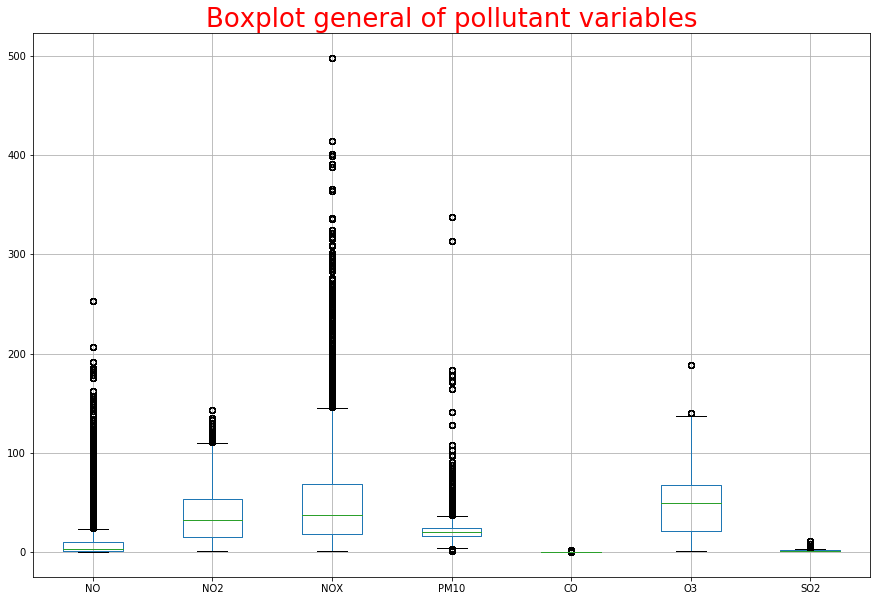

In [26]:
axes=data_air_hourly.boxplot(figsize=(15,10))
plt.title("Boxplot general of pollutant variables", fontsize=26, color='red')
plt.show()

La misma información la podemos representar agrupando los datos para cada variable por estaciones.

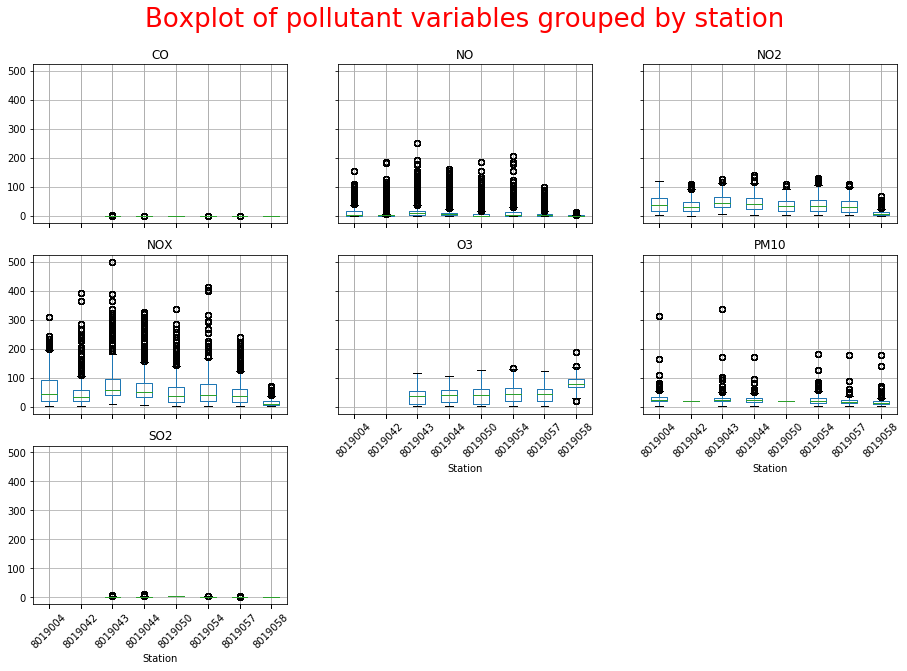

In [27]:
bp=data_air_hourly.boxplot(by=['CODI_EOI'],figsize=(15,10),rot=45)
[ax_tmp.set_xlabel('Station') for ax_tmp in np.asarray(bp).reshape(-1)]
fig = np.asarray(bp).reshape(-1)[0].get_figure()
fig.suptitle('Boxplot of pollutant variables grouped by station', fontsize=26, color='red')
plt.show()

Podemos observar, en estas figuras, la presencia de valores extremos. Sin embargo, en nuestro caso, optaremos por mantener estos datos, pues se entiende que son valores correctamente observados y posibles. También vemos en este gráfico, como no todos los contaminantes, de los que tenemos datos, son registrados en todas las estaciones. Así, por ejemplo, hay dos estaciones que no registran datos ni de CO, ni de O<sub>3</sub>, ni de SO<sub>2</sub>.

Vemos otra forma de representar esta información agrupando los datos de contaminación registrados para cada estación de vigilancia. 

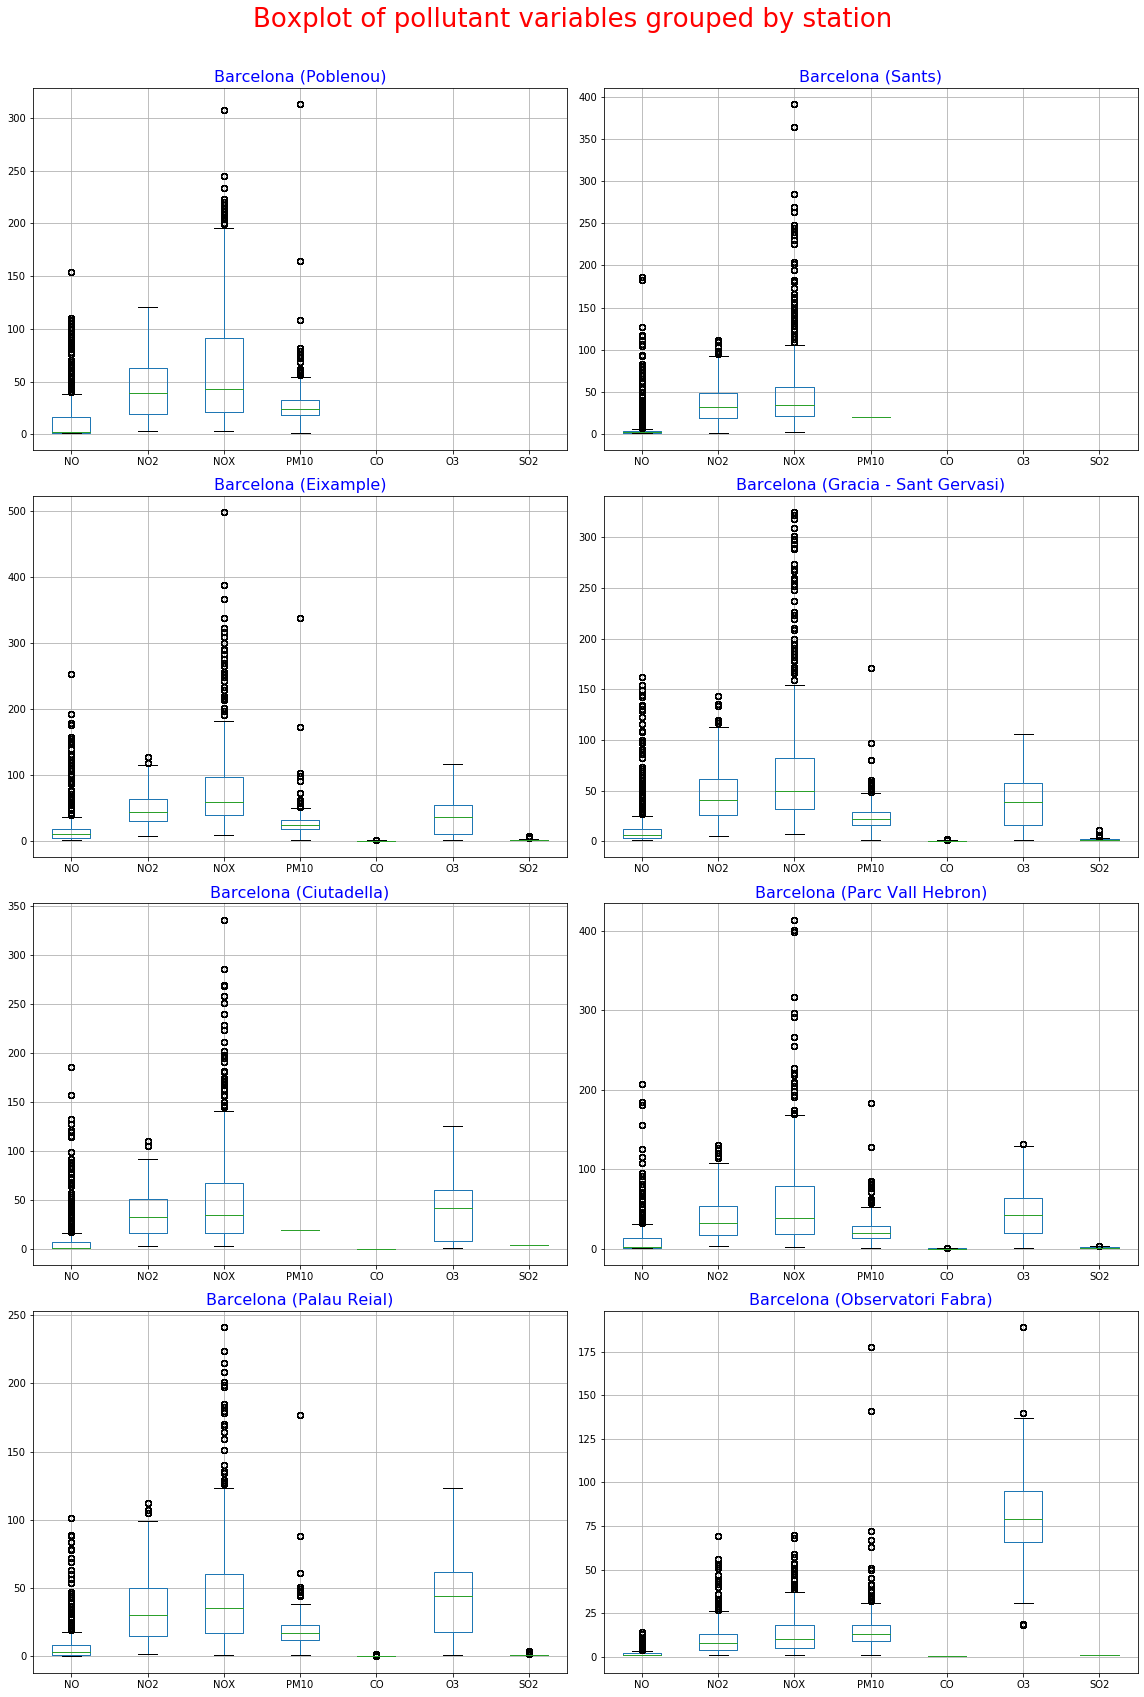

In [28]:
codiEois = data_air_hourly['CODI_EOI'].unique()
nroItems=len(codiEois)
ncols=2
nrows=int((nroItems / ncols) + (nroItems % ncols))

codiEois=np.append(codiEois, [None] * (nroItems % ncols))
        
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*8,nrows*6))
for codiEoi, ax in zip(codiEois, axes.flatten()):
    if codiEoi:
        nom_estacio=data_air_stations.loc[codiEoi,'NOM_ESTACIO']
        title='{}'.format(nom_estacio)
        data_air_hourly[data_air_hourly["CODI_EOI"] == codiEoi].boxplot(ax=ax)
        ax.set_title(title, fontsize=16, color='blue')
    else:
        ax.remove()
plt.suptitle('Boxplot of pollutant variables grouped by station', fontsize=26, color='red')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

A continuación, evaluaremos la variabilidad de cada una de estas variables en el tiempo. Para ello, representamos los valores para cada una de los contaminantes, en cada una de las estaciones, con la variable de tiempo, 'DATA', en el eje de abscisas.

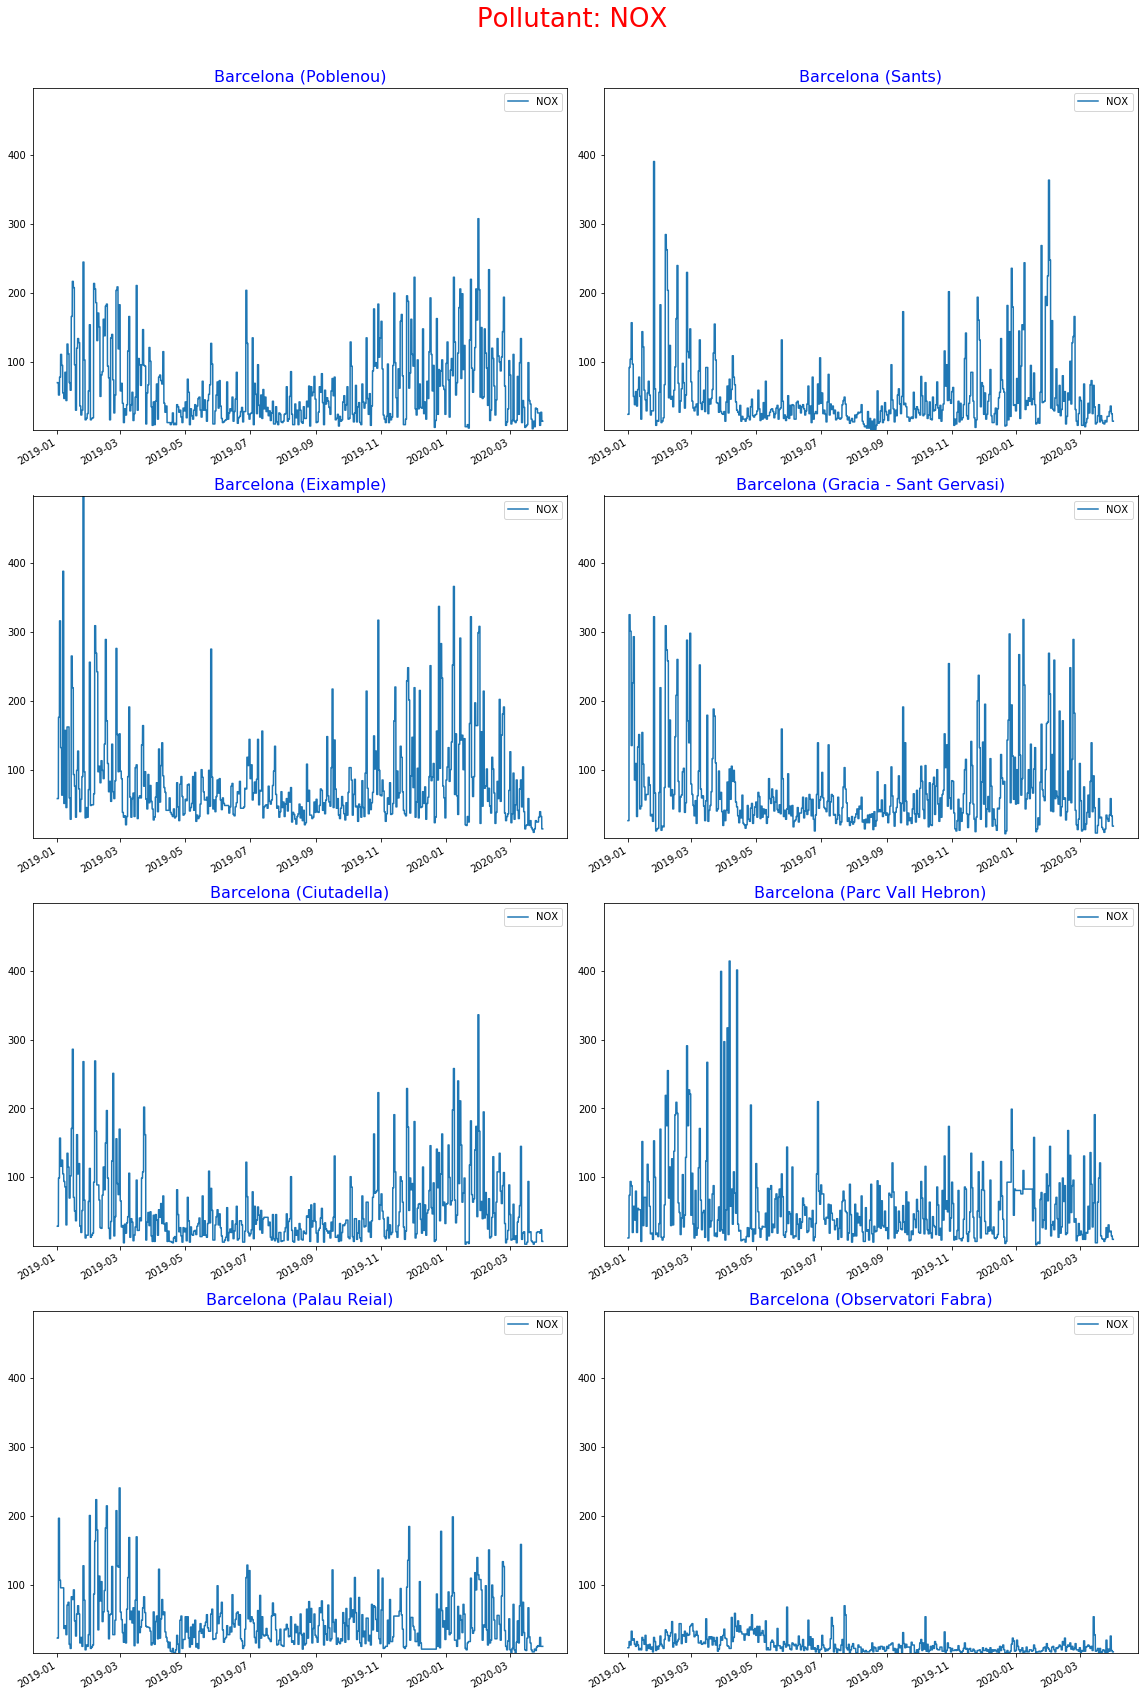

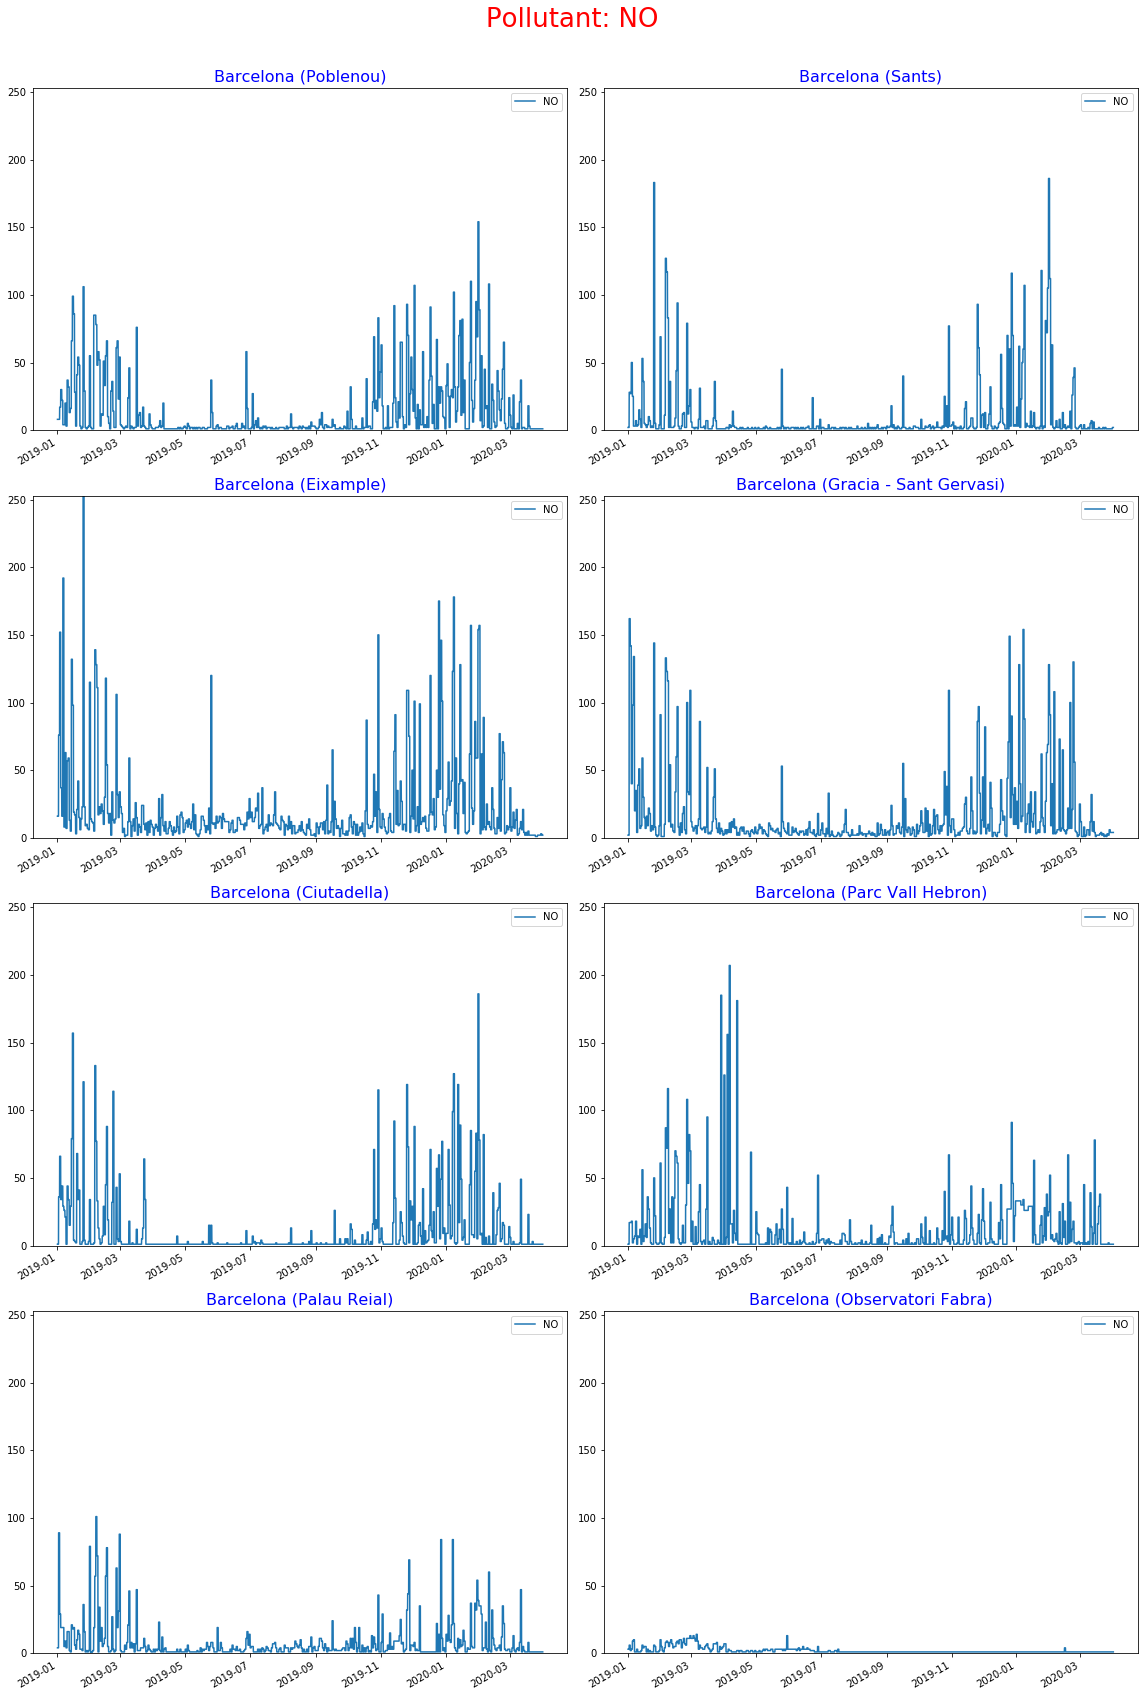

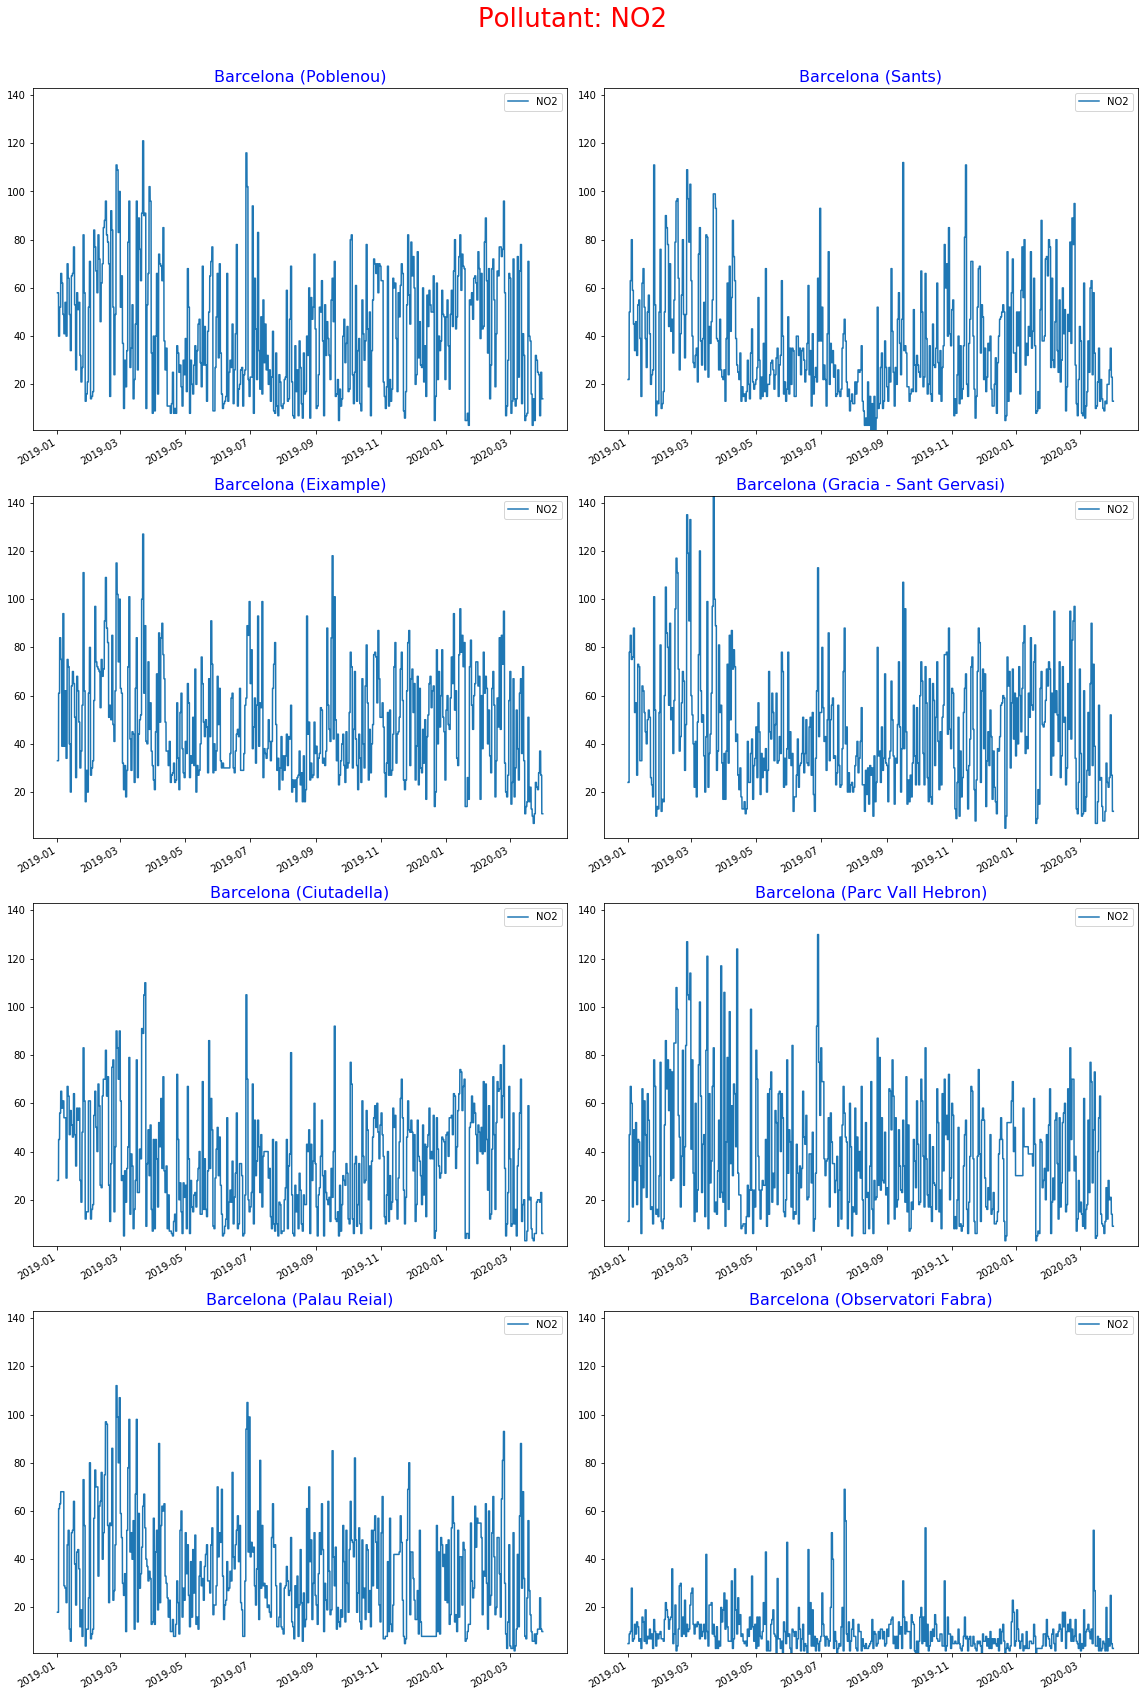

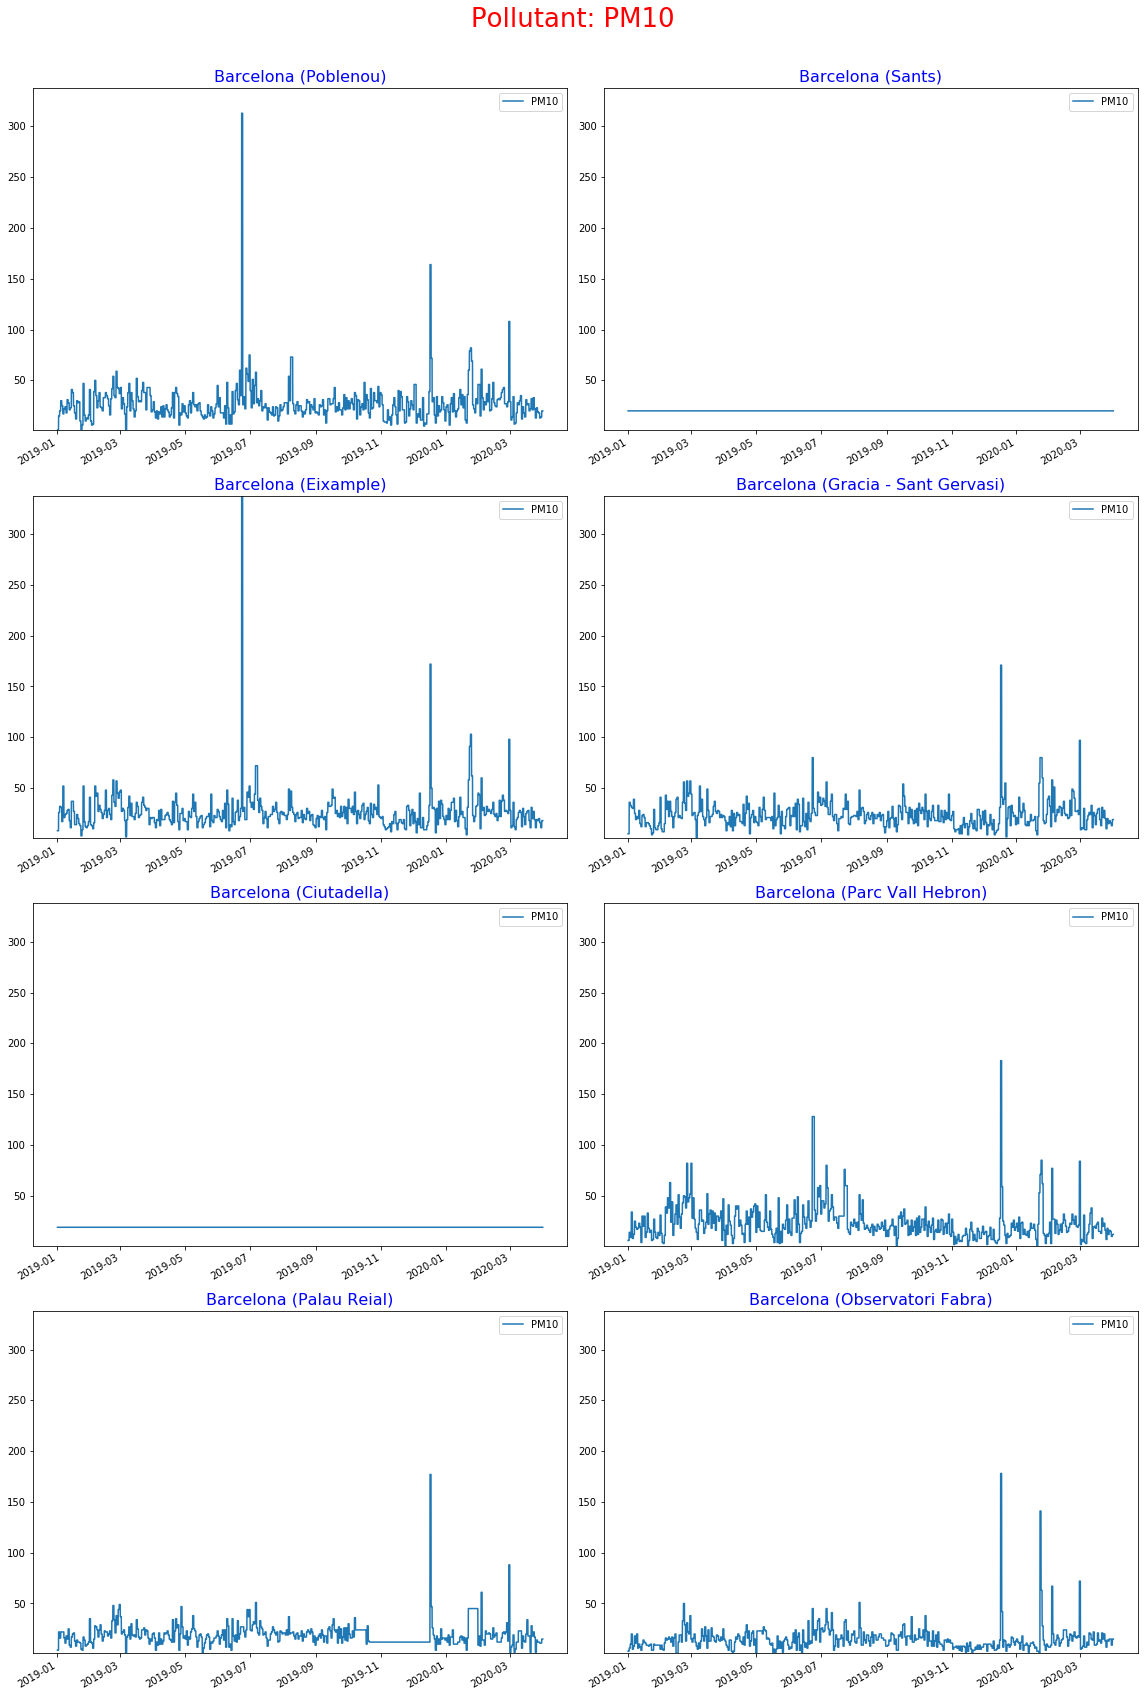

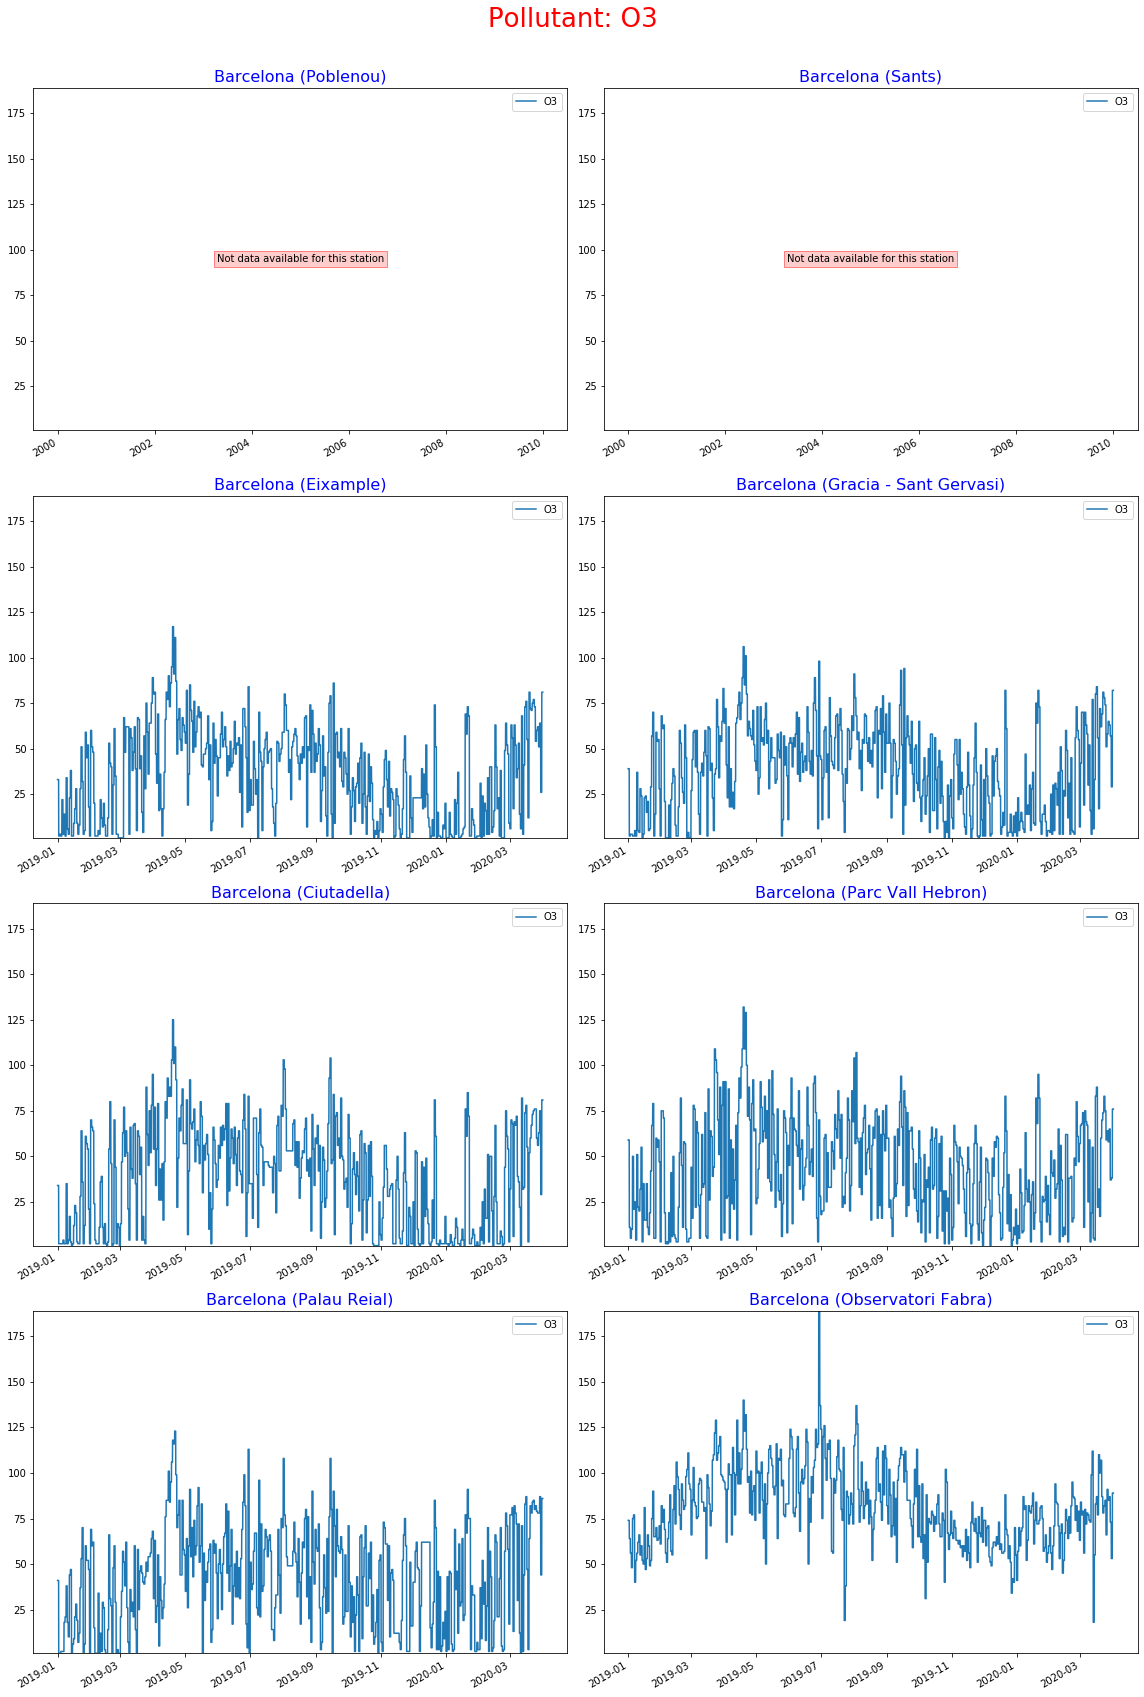

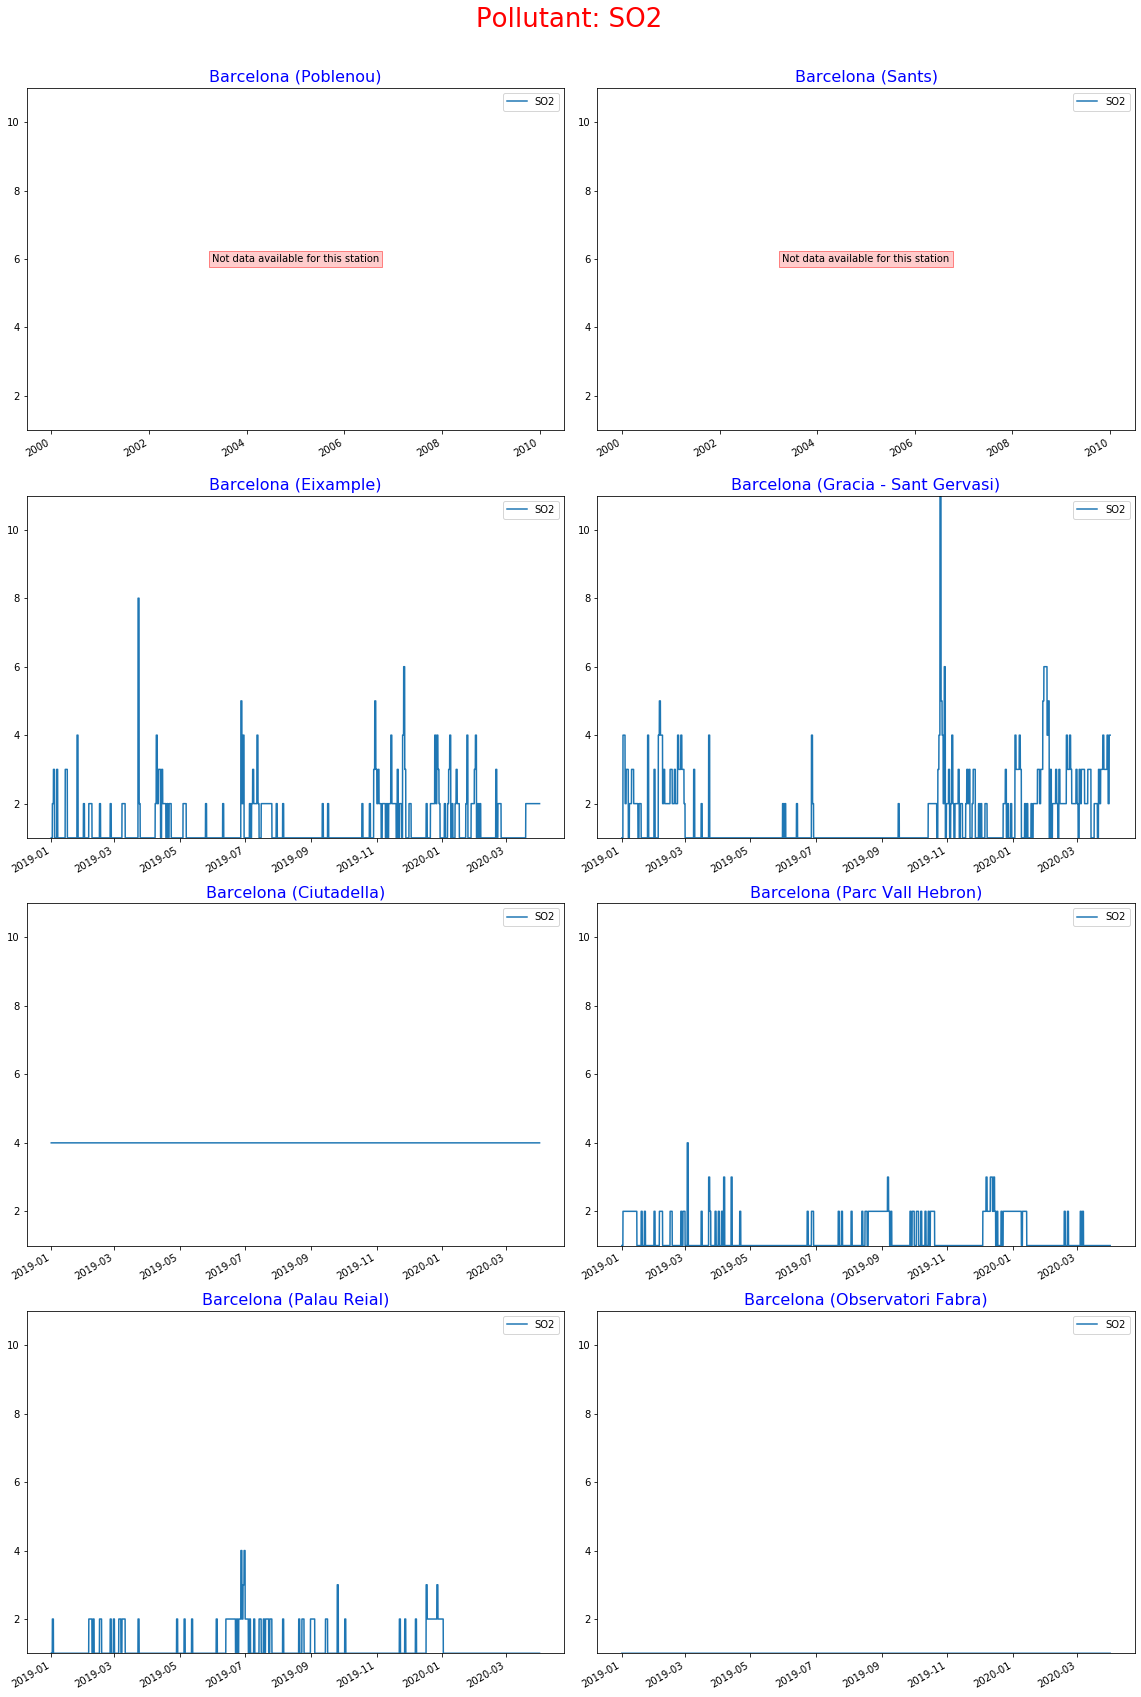

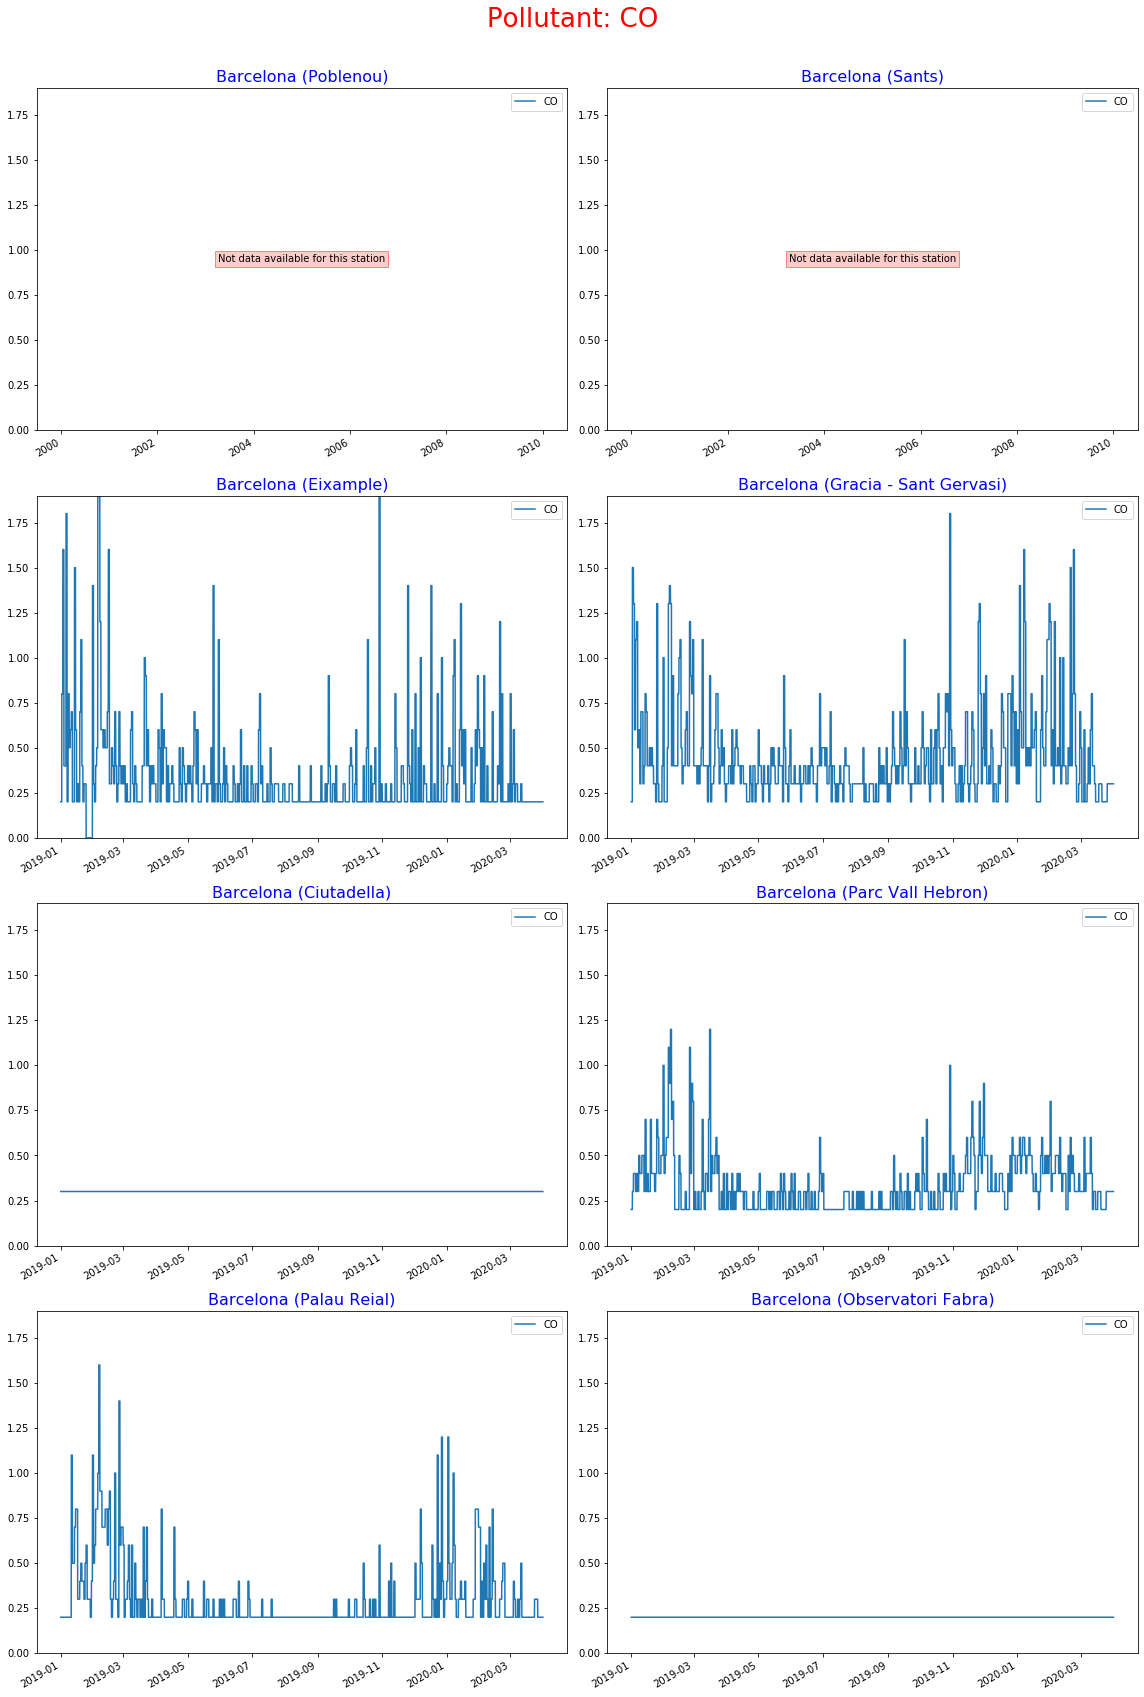

In [29]:
idStations = data_air_hourly['CODI_EOI'].unique()
nroItems=len(idStations)
ncols=2
nrows=int((nroItems / ncols) + (nroItems % ncols))

idStations=np.append(idStations, [None] * (nroItems % ncols))

variables=data_air['CONTAMINANT'].unique()
#variables=np.array(['NO', 'NO2','NOX','PM10','CO','O3','SO2'])

for variable in variables:
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*8,nrows*6))
    for idStation, ax in zip(idStations, axes.flatten()) :
        if idStation:
            nom_estacio=data_air_stations.loc[idStation,'NOM_ESTACIO']
            title='{}'.format(nom_estacio)
            data=data_air_hourly.loc[(data_air_hourly["CODI_EOI"] == idStation), ['DATA', variable]].set_index('DATA')
            if data.count()[0] > 0:  
                data.plot(ax=ax)     
                ax.set_ylim(stats[variable]['min'],stats[variable]['max'])
                ax.set_title(title, fontsize=16, color='blue')
                ax.set_xlabel('')
            else:
                data.plot(ax=ax)
                text='Not data available for this station'
                ax.text(0.5, 0.5, text, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,
                        bbox=dict(boxstyle="square", ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))
                #plt.text(5, 5, text, ha='right', rotation=-15, wrap=True)
                ax.set_ylim(stats[variable]['min'],stats[variable]['max'])
                ax.set_title(title, fontsize=16, color='blue')
                ax.set_xlabel('')
        else:
            ax.remove()
        
    plt.suptitle('Pollutant: {}'.format(variable), fontsize=26, color='red')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Bibliografía

- Numpy developer manual. https://numpy.org/devdocs/

- Pandas documentation. https://pandas.pydata.org/docs/

- Folium. https://python-visualization.github.io/folium/